In [1]:
%cd ..

/home/nikolay/Documents/Projects/Diploma/My repos/Pseudo_label_Grounding_DINO


In [2]:
import os
import glob
import pandas as pd
from utils import AnnotationDF, draw_annotations
import cv2
import matplotlib.pyplot as plt
import tqdm

In [3]:
classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 
    'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [4]:
class Detection():
    def __init__(self, entry) -> None:
        self.image_name = entry['image_name']
        self.class_name = entry['class']
        self.class_index = entry['class_index']
        self.num_boxes = entry['num_boxes']
        self.probability = entry['probability']
        self.bbox_string = entry['bbox']
        self.bbox = [float(x) for x in entry['bbox'].split(' ')]
        self.box_area = entry['box_area']

    def get_IoU(self, another):
        intersection_h_max = min(self.bbox[1] + (self.bbox[3]/2), another.bbox[1] + (another.bbox[3]/2))
        intersection_h_min = max(self.bbox[1] - (self.bbox[3]/2), another.bbox[1] - (another.bbox[3]/2))
        intersection_w_max = min(self.bbox[0] + (self.bbox[2]/2), another.bbox[0] + (another.bbox[2]/2))
        intersection_w_min = max(self.bbox[0] - (self.bbox[2]/2), another.bbox[0] - (another.bbox[2]/2))   
        intersection_area = (intersection_h_max - intersection_h_min) * (intersection_w_max - intersection_w_min)
        union = self.box_area + another.box_area - intersection_area
        return round(intersection_area / union, 3)

In [5]:
def search_image_names(path, extensions=['jpeg', 'jpg']):
    files = []
    for ext in extensions:
        files.extend(glob.glob(path + '/*' + ext))
    files = [os.path.split(x)[-1].split('.')[0] for x in files]
    return sorted(files)

In [6]:
def nms_filter(detections, iou_threshold):
    keep_list = [detections[0]]
    for detection in detections[1:]:
        keep = True
        for sample in keep_list:
            if sample.get_IoU(detection) > iou_threshold:
                keep = False
                break
        if keep:
            keep_list.append(detection)
    return keep_list

def nms_filter_one_class(detections, iou_threshold):
    keep_list = [detections[0]]
    for detection in detections[1:]:
        keep = True
        for sample in keep_list:
            if (sample.class_index == detection.class_index) and (sample.get_IoU(detection) > iou_threshold):
                keep = False
                break
        if keep:
            keep_list.append(detection)
    return keep_list

def dumb_probability_filter(detections, probability_threshold):
    keep_list = []
    for detection in detections:
        if detection.probability >= probability_threshold:
                keep_list.append(detection)
    return keep_list



In [7]:
def write_COCO_annotaion(save_dir, image_name,  annotaions):
    filename = os.path.join(save_dir, image_name + '.txt')
    lines = [str(x[0]) + ' ' + x[1] + '\n' for x in annotaions]
    with open(filename, 'x') as f:
        f.writelines(lines)


In [8]:
def create_single_detection(detections, filters):
    if len(detections) == 0:
        return []
    else:
        detections = sorted(detections, key=lambda x: x.probability, reverse=True)
        for filter, filter_args in filters:
            detections = filter(detections, **filter_args)
        # [print(x.probability) for x in detections]
        return [(x.class_index, x.bbox_string) for x in detections]

## Create COCO annotation


In [9]:
def create_annotations(save_path, image_path, ann_path, filters):
    # search image names
    image_names = search_image_names(image_path)
    os.makedirs(save_path, exist_ok=True)
    if len (os.listdir(save_path)) > 0:
        print('directory not empty')
        return 

    #load annotation dataframe
    annotation_df = AnnotationDF(classes)
    annotation_df.load_annotation(ann_path)
    
    for image_name in tqdm.tqdm(image_names):
        detections = [Detection(x[1]) for x in annotation_df.df.loc[annotation_df.df['image_name'] == image_name].iterrows()]
        annotation = create_single_detection(detections, filters)
        write_COCO_annotaion(save_path, image_name, annotation)

In [27]:
nms_filter_args = {'iou_threshold':0.7}
# nms_filter_one_class_args = {'iou_threshold':0.5}
dumb_probability_filter_args = {'probability_threshold':0.4}

filters = [
    (nms_filter, nms_filter_args),
    # (nms_filter_one_class, nms_filter_one_class_args),
    (dumb_probability_filter, dumb_probability_filter_args)
]



val_img_path = 'datasets/VOC/images/val'
val_ann_path = 'data/VOC/val'
val_save_path= f'data/VOC/labels/annotations_nms_{list(nms_filter_args.values())[0]}_p_{list(dumb_probability_filter_args.values())[0]}/val'

train_img_path = 'datasets/VOC/images/train'
train_ann_path = 'data/VOC/train'
train_save_path= f'data/VOC/labels/annotations_nms_{list(nms_filter_args.values())[0]}_p_{list(dumb_probability_filter_args.values())[0]}/train'

test_img_path = 'datasets/VOC/images/test'
test_ann_path = 'data/VOC/test'
test_save_path= f'data/VOC/labels/annotations_nms_{list(nms_filter_args.values())[0]}_p_{list(dumb_probability_filter_args.values())[0]}/test'

In [30]:
create_annotations(save_path=val_save_path, 
                   image_path=val_img_path, 
                   ann_path=val_ann_path, 
                   filters=filters)


100%|██████████| 2510/2510 [00:35<00:00, 71.55it/s]


In [2]:
# %cd data/VOC/labels
# !zip annotations_nms_0.7_p_0.4.zip annotations_nms_0.7_p_0.4 -r 
# %cd ..
# %cd ..
# %cd ..

/home/nikolay/Documents/Projects/Diploma/My repos/Pseudo_label_Grounding_DINO/data/VOC/labels
  adding: annotations_nms_0.7_p_0.4/ (stored 0%)
  adding: annotations_nms_0.7_p_0.4/train/ (stored 0%)
  adding: annotations_nms_0.7_p_0.4/train/004902.txt (deflated 45%)
  adding: annotations_nms_0.7_p_0.4/train/003921.txt (deflated 41%)
  adding: annotations_nms_0.7_p_0.4/train/002191.txt (deflated 27%)
  adding: annotations_nms_0.7_p_0.4/train/007572.txt (deflated 44%)
  adding: annotations_nms_0.7_p_0.4/train/005923.txt (deflated 49%)
  adding: annotations_nms_0.7_p_0.4/train/000726.txt (deflated 26%)
  adding: annotations_nms_0.7_p_0.4/train/008559.txt (deflated 41%)
  adding: annotations_nms_0.7_p_0.4/train/000859.txt (deflated 45%)
  adding: annotations_nms_0.7_p_0.4/train/000605.txt (deflated 25%)
  adding: annotations_nms_0.7_p_0.4/train/007885.txt (deflated 26%)
  adding: annotations_nms_0.7_p_0.4/train/002405.txt (deflated 40%)
  adding: annotations_nms_0.7_p_0.4/train/007075.txt (

### Visualization

In [13]:
load_df = AnnotationDF(classes)
load_df.load_annotation(test_ann_path)
load_df.df['image_name'].unique()[:20]

array(['000001', '000002', '000003', '000004', '000006', '000008',
       '000010', '000011', '000013', '000014', '000015', '000018',
       '000022', '000025', '000027', '000028', '000029', '000031',
       '000037', '000038'], dtype=object)

In [24]:
image_name

'000001'

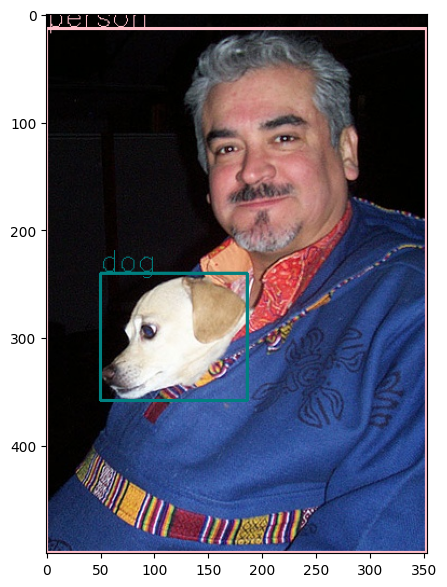

In [26]:
# image_name = '000012'
image_name = load_df.df['image_name'].unique()[0]


detections = [Detection(x[1]) for x in load_df.df.loc[load_df.df['image_name'] == image_name].iterrows()]
# Filters
nms_filter_args = {'iou_threshold':0.5}
nms_filter_one_class_args = {'iou_threshold':0.7}
dumb_probability_filter_args = {'probability_threshold':0.4}

filters = [
    (nms_filter, nms_filter_args),
    (nms_filter_one_class, nms_filter_one_class_args),
    (dumb_probability_filter, dumb_probability_filter_args)
]
annotation = create_single_detection(detections, filters)



image_file = f'datasets/VOC/images/test/{image_name}.jpg'
image = cv2.imread(image_file, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

prep_annotaions = []
for ann in annotation:
    prep = [float(x) for x in ann[1].split(' ')]
    prep.insert(0, ann[0])
    prep_annotaions.append(prep)

plt.figure(figsize = (7,7))
plt.imshow(draw_annotations(image, prep_annotaions, class_names=classes)[0])
